# Stock Clustering

We build an unsupervised model that clusters stocks based on how their returns behave within a given time window. The model identifies groups of similarly behaving assets without using any industry labels. We then extend this approach with a method for tracking how the clusters change over time, so that the model captures both the stable structure of the market and the shifts that occur during periods of volatility.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import model

sys.path.append(os.path.abspath(os.path.join('..', 'data')))
from default_tickers import default_tickers

import warnings
warnings.simplefilter("ignore", category = FutureWarning)

## Prediciting Industry Labels

For this project, we use stocks from the default_tickers.py file, which provides a balanced selection across several industries: tech, energy, finance, healthcare, utilities, materials, and real estate. While these stocks are grouped by industry, the model does not use these labels during training. Its most basic functionality is to identify shared behavioral patterns among stocks and use this information to predict their industry affiliation.

To illustrate this, we focus on a representative subset of stocks drawn from the tech, finance, real estate, and utilities sectors. This choice is deliberate: these industries are relatively easy to separate into two broad behavioral groups. Real estate and utilities are commonly referred to as defensive stocks — they typically exhibit low volatility, stable returns, and are less sensitive to macroeconomic shocks. Tech and finance, by contrast, tend to be cyclical or offensive sectors — their returns are more volatile and closely tied to economic sentiment, growth expectations, and market cycles.

In what follows, we set the model parameter n_clusters, which controls the number of output clusters, to two, and run the model over a relatively calm market period between January 2023 and January 2024.


Dataset constructed: 4 industries × 40 complete series each = 160 total samples. Sample length is 249.


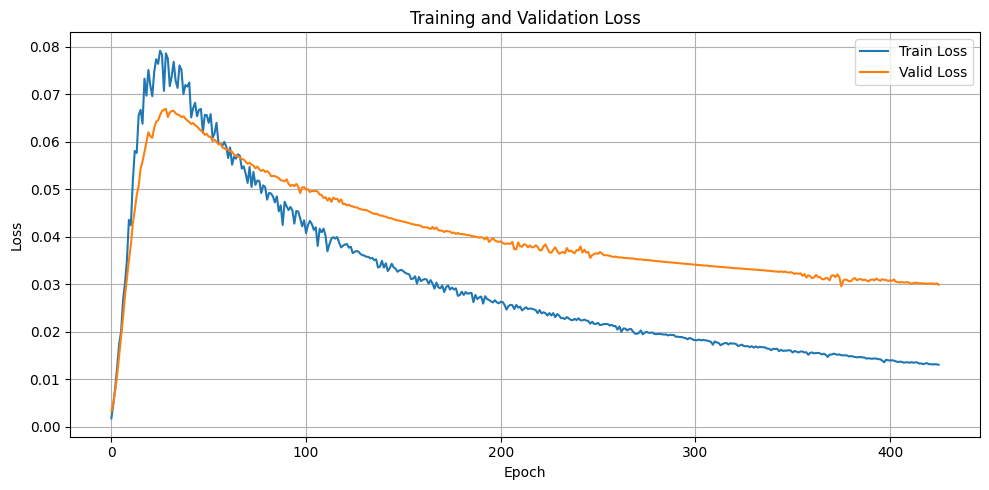

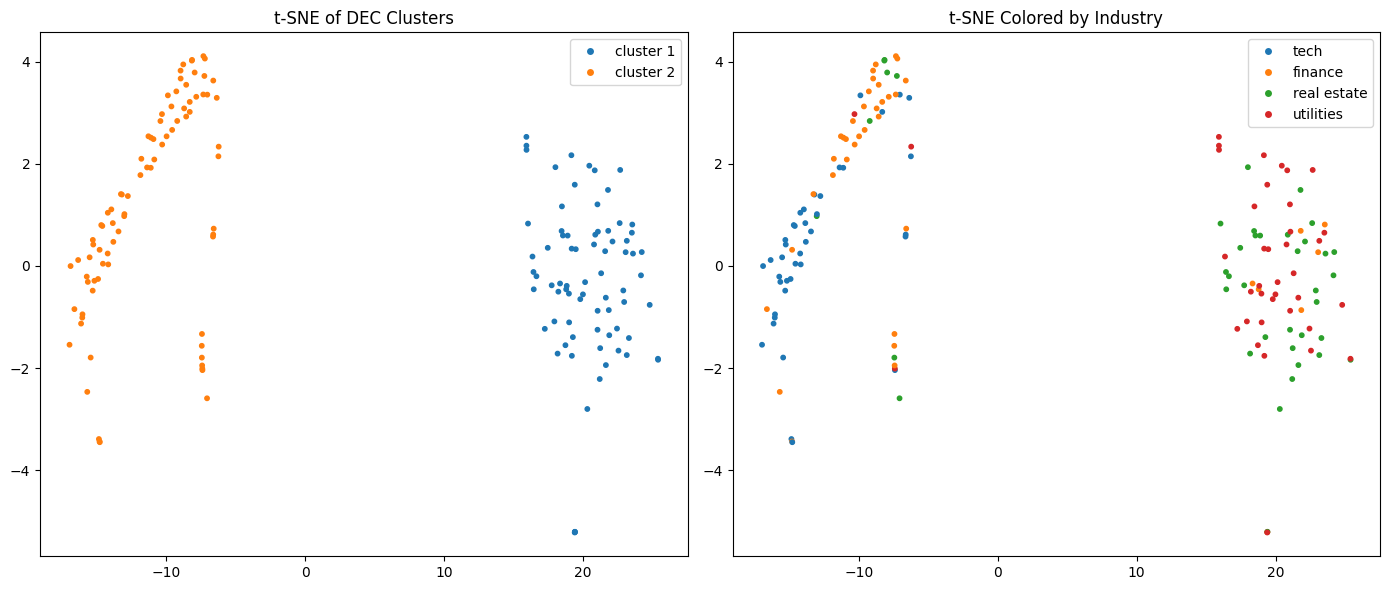


Proportion of each industry assigned to each cluster:

             cluster 1  cluster 2
finance           0.17       0.82
real estate       0.80       0.20
tech              0.00       1.00
utilities         0.93       0.07


In [30]:
X, y, t, industry_keys, _ = model.build_dataset(default_tickers, '2023-01-01', '2024-01-01', industries = ['tech', 'finance', 'real estate', 'utilities'], shuffle = True)

train, valid = model.prepare_dataloaders(X)
dec, history = model.train_model(train, valid, max_epochs = 800, n_clusters = 2)
z, clusters = model.predict_clusters(dec, X)

model.plot_loss_history(history)
model.plot_tsne_clusters(clusters, y, z, industry_keys)
model.mixing_table(clusters, y, industry_keys, verbose = True);

As shown in the results above, our model successfully grouped the majority of real estate and utility stocks into cluster 1, while most tech and finance stocks were classified into cluster 2. This highlights the model's ability to recognize and cluster stocks based on characteristic industry behavior — despite having no access to industry labels during training. This demonstrates that the model captures broad behavioral patterns across industries — but its capabilities go well beyond this static classification. As we’ll see next, it can also track how these relationships shift over time.

## Cluster evolution

While clustering stocks within a single time window is already insightful, the main goal of this project is to track how these cluster assignments evolve as the window slides along the time axis. This is also a more reliable question to ask, since predictions within a single window can fluctuate, making them somewhat noisy. By analyzing the resulting time series of cluster assignments, we can smooth out these fluctuations and highlight the underlying trends.

We slide the model’s window across the period between start and end, chosen here to center around the March 2020 COVID crash — the event of primary interest, where some stocks have deviated from their industry averages. The parameter `window` specifies the length of each training window, while `step` controls how far the window shifts forward with each iteration of the model.

In [11]:
start, end = '2018-01-01', '2023-01-01'
window, step = 60, 15

Before we begin, there are two important notes about the internal workings of the model:

Note 1: At each window position, the model is trained independently. The initial clustering for the first window is generated using K-means, while for all subsequent windows, the model is initialized with the cluster centroids obtained from the previous window. This greatly improves the model's performance. Despite this, the resulting time series of industry proportions tends to be noisy. To recover the underlying trend, we apply a rolling median. To view the raw, unsmoothed series, use `plot_cluster_proportions` without the `rolling_window` parameter.

Note 2: Tracking the time evolution of K-means clusters is inherently challenging. Even when using the previous centroids as initialization, there is no guarantee that the resulting cluster labels remain consistent between adjacent windows. To address this, we relabel the clusters in each window to maximize overlap with the corresponding clusters from the previous one. This relabeling works well during periods of stability but can fail when cluster compositions fluctuate rapidly, resulting in label flips.

To mitigate this, we introduce a `lock_threshold` parameter. When a given industry exceeds the threshold (e.g., 90%) in its assignment to a specific cluster, that assignment becomes locked: future relabeling steps are constrained to preserve it. This substantially reduces label instability over time. While this may slightly restrict the model's flexibility, it primarily rules out highly unstable configurations that are unlikely to reflect meaningful real-world behavior.

### Tech & Real Estate

We will start with the simplest possible example involving two distinctly different families of stocks. Tech stocks, such as `AAPL`, `MSFT`, and `GOOGL`, are known to be highly sensitive to macroeconomic sentiment and growth expectations. These stocks typically exhibit higher market beta and pronounced volatility clustering. In contrast, real estate stocks like `PLD`, `AMT`, and `EQIX` display the opposite behavior — lower sensitivity to growth shocks and flatter return profiles. We fully expect the model to learn to distinguish between these two groups. Running the model with two target clusters yields the following behavior of stock proportions in each cluster:

Computing cluster-industry proportions: 100%|██████████| 80/80 [02:00<00:00,  1.51s/it]


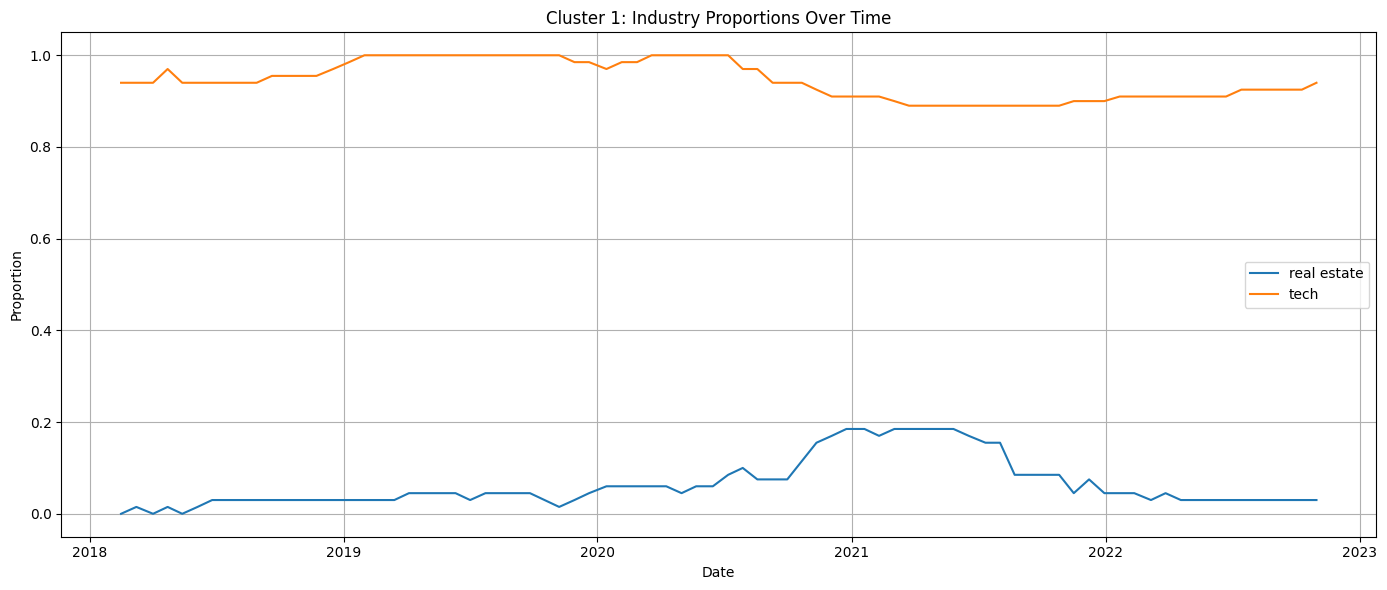

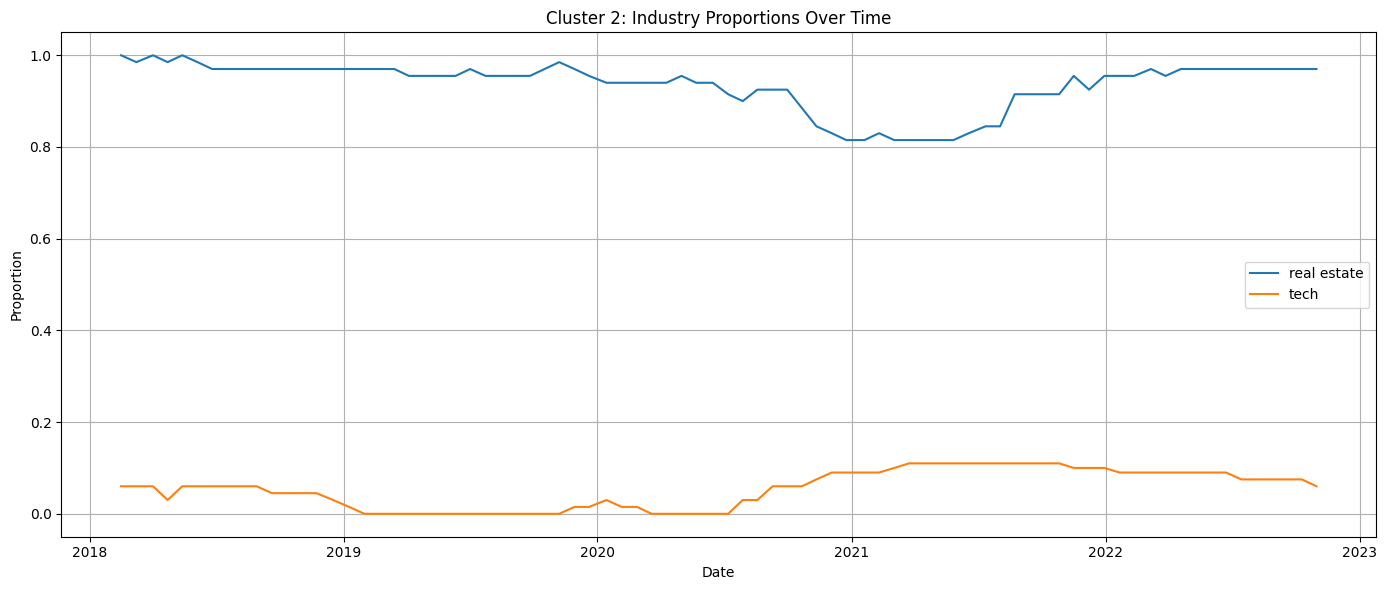

In [ ]:
evolution = model.cluster_evolution(default_tickers, start, end, 2, industries = ["tech", "real estate"], window = window, step = step, lock_threshold = 0.9)
model.plot_cluster_proportions(evolution, rolling_window = 10)

These two industries remain remarkably well separated, even during the crash, and our model has no difficulty identifying this distinction.

### Finance & Energy

We now turn to a slightly more subtle example involving two industries that are less cleanly separable: finance and energy. Finance stocks such as `BRK-B`, `JPM`, and `MSCI` typically exhibit moderate sensitivity to macroeconomic fluctuations, often reflecting changes in credit conditions or interest rates. Energy stocks like `XOM`, `CVX`, and `SLB`, on the other hand, are primarily driven by commodity prices, geopolitical risks, and inflation dynamics. While these industries are fundamentally different, their behaviors can become correlated under certain macroeconomic regimes.

This is exactly what we observe in the plot below. Throughout most of the sample period, the model correctly assigns nearly all energy stocks to one cluster and finance stocks to another. However, during the Covid crash of March 2020, a temporary blending occurs: a notable portion of finance stocks migrate into the energy cluster. This behavior is not a failure of the model but rather a reflection of genuine market dynamics. During the crash, energy stocks experienced extreme volatility due to the collapse in oil prices, and many finance stocks suddenly mirrored this volatility as a result of panic selling, liquidity concerns, and systemic stress. Specific examples of finance stocks that temporarily migrated to the energy cluster include COF, AXP, and MET. 

This behavior is captured by our model:

Computing cluster-industry proportions: 100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


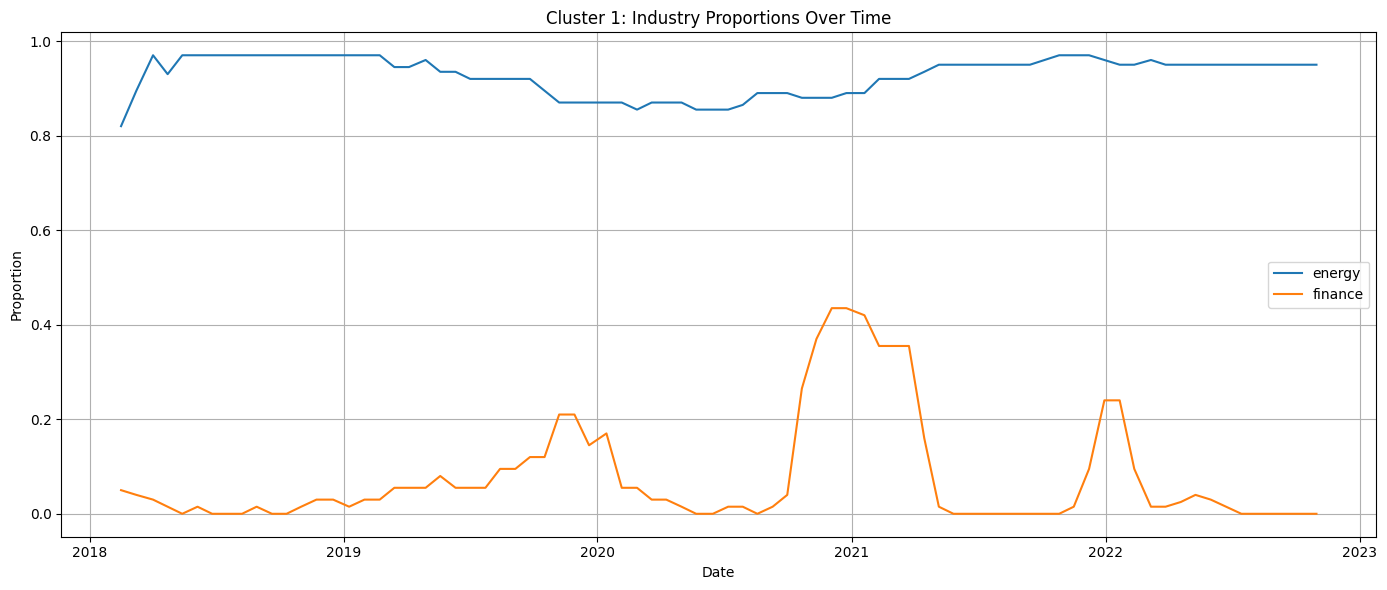

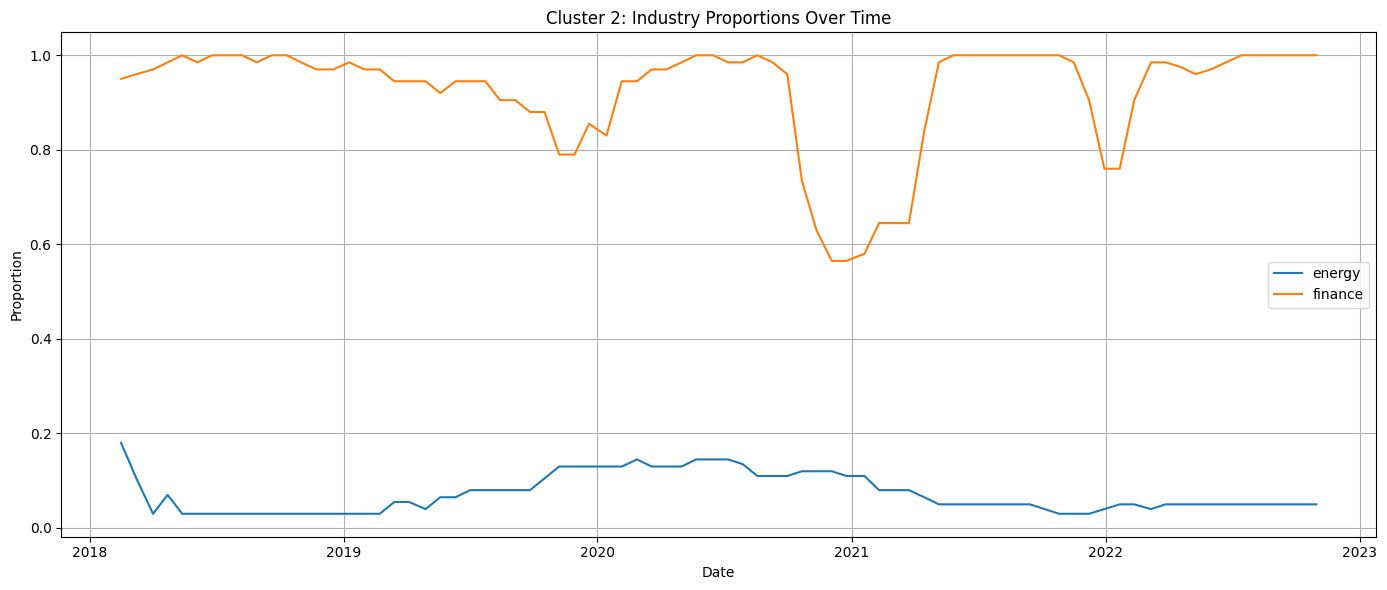

In [ ]:
evolution = model.cluster_evolution(default_tickers, start, end, 2, industries = ["energy", "finance"], window = window, step = step, lock_threshold = 0.8)
model.plot_cluster_proportions(evolution, rolling_window = 10)

Let us take a closer look at this behavior. We can train a model to specifically analyze the large spike around Jan 2021.

In [5]:
left, right = '2020-10-01', '2021-04-01'

X, y, t, industry_keys, _ = model.build_dataset(default_tickers, left, right, industries = ['finance', 'energy'], shuffle = True)

train, valid = model.prepare_dataloaders(X)
dec, history = model.train_model(train, valid, max_epochs = 800, n_clusters = 2)
z, clusters = model.predict_clusters(dec, X)


Dataset constructed: 2 industries × 40 complete series each = 80 total samples. Sample length is 124.


The predictions are in line with the general analysis above.

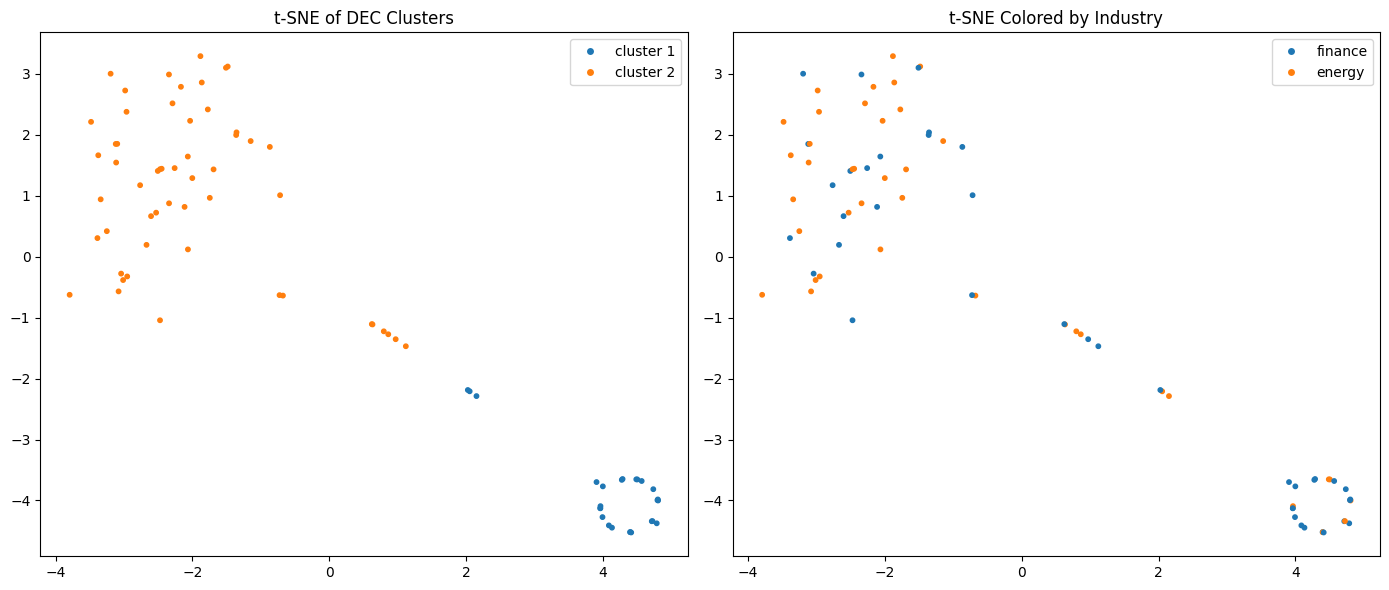


Proportion of each industry assigned to each cluster:

         cluster 1  cluster 2
energy        0.20       0.80
finance       0.45       0.55


In [6]:
model.plot_tsne_clusters(clusters, y, z, industry_keys)
model.mixing_table(clusters, y, industry_keys, verbose = True);

Let us look at some of the finance stocks that migrate to the other cluster (note that upon re-running the model training loop above, clusters might get re-labelled):

In [7]:
df = model.tickers_by_cluster(clusters, y, t, industry_keys)
print('Finance stocks that migrated: ', ', '.join(df.loc['finance', 'cluster 1']))
print('Finance stocks that didn\'t migrate: ', ', '.join(df.loc['finance', 'cluster 2']))

Finance stocks that migrated:  MCO, MA, WTW, BX, KKR, V, MMC, PYPL, NDAQ, TROW, ICE, BLK, AON, IVZ, CBOE, SPGI, APO, MSCI
Finance stocks that didn't migrate:  ALL, TRV, BK, PRU, PFG, MET, UNM, CFG, SCHW, COF, CMA, HBAN, KEY, LNC, STT, AMP, BRK-B, AXP, BEN, RJF, FITB, EVR


To represent the behavior of stocks in cluster 1, we can plot normalized log returns for one of the migrated stocks `COF`, along with a typical energy stock `SHEL`. For cluster 2, we plot two typical energy stocks `ICE` and `ALL`:

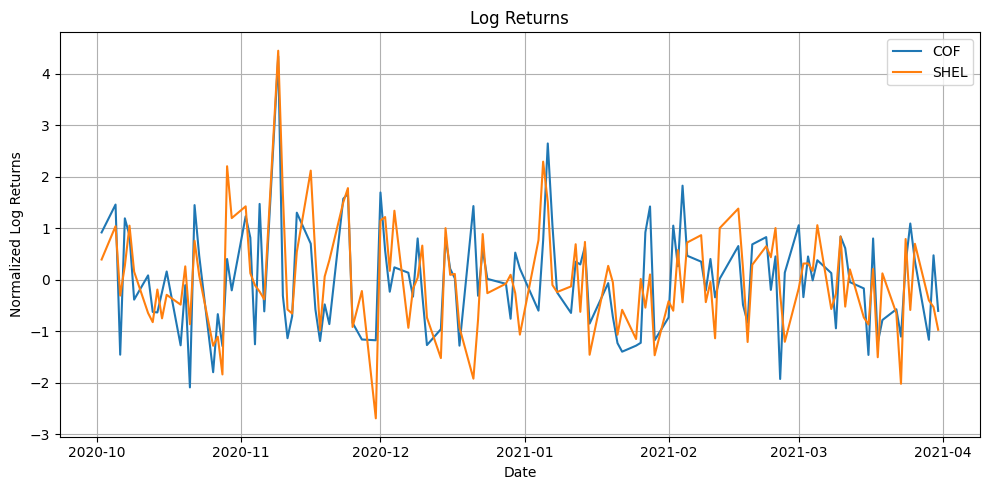

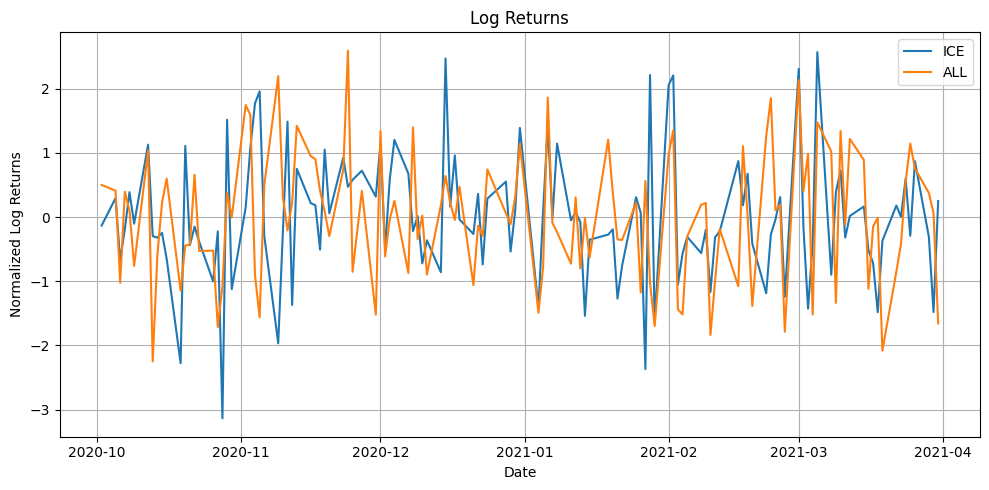

In [ ]:
model.plot_log_returns(['COF', 'SHEL'], left, right, normalize = True)
model.plot_log_returns(['ICE', 'ALL'], left, right, normalize = True)

### Tech & Real Estate & Healthcare - 2 clusters



We can now see how our model fares when it is tasked with classifying several industries rather than just two. We begin with the tech and real estate industries, which we have already seen to be well-separated in previous experiments, and add to them a third: healthcare. This new group shares no strong behavioral similarities with either tech or real estate, making the clustering task more ambiguous.

Healthcare stocks tend to sit between the extremes of high-volatility tech stocks and the flatter profiles of real estate. Companies like `JNJ`, `UNH`, and `ABBV` typically offer more defensive characteristics, while names like `MRNA`, `VRTX`, and `REGN` exhibit more volatile, growth-driven behavior.

We now run the model on these three industries but still only ask it to form two clusters. This forces the model to make a choice: does it group healthcare with tech, with real estate, or treat it inconsistently?

Computing cluster-industry proportions: 100%|██████████| 80/80 [02:07<00:00,  1.60s/it]


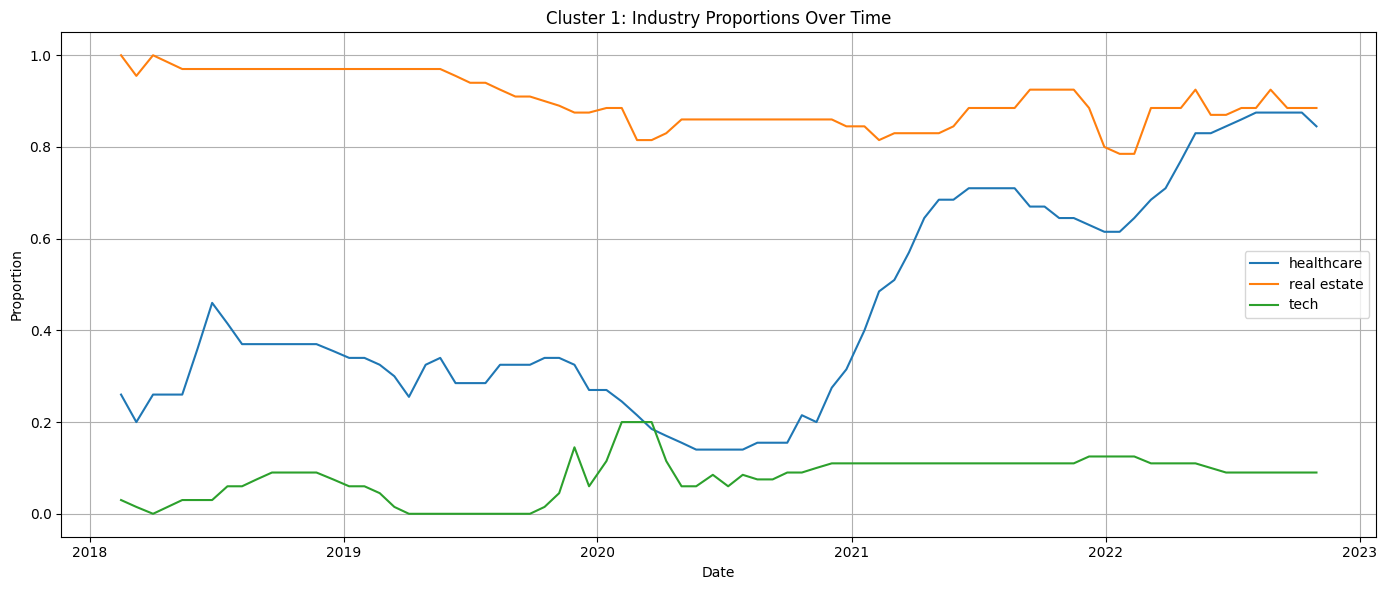

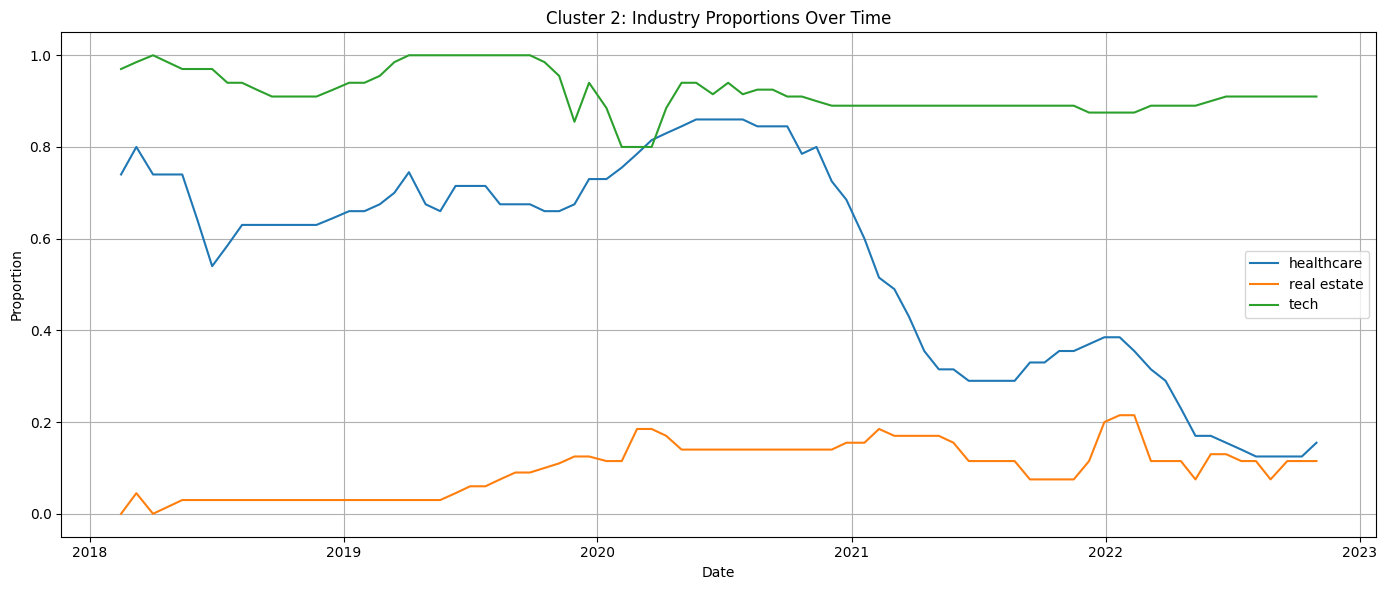

In [ ]:
evolution = model.cluster_evolution(default_tickers, start, end, 2, industries = ["tech", "real estate", "healthcare"], window = window, step = step, lock_threshold = 0.9)
model.plot_cluster_proportions(evolution, rolling_window = 10)

At first, healthcare stocks are split somewhat evenly between the two clusters, with a slight tilt toward the tech-dominated cluster. But in the immediate aftermath of the Covid crash, we see a growing share of healthcare companies shift into the real estate-dominated cluster. This reflects a change in their behavior — as the pandemic unfolded, many tech-oriented healthcare stocks began to exhibit more defensive characteristics. This experiment highlights a key strength of the model: its ability to capture shifts in industry behavior without any explicit labeling. Having a clear picture of how certain industries behave during crises can help inform expectations in future periods of market stress.

### Tech & Real Estate & Healthcare - 3 clusters

In our earlier experiment with two clusters, the model had no way of isolating the healthcare sector on its own. Instead, it treated healthcare stocks as something like an intermediate state — sometimes grouping them with tech, sometimes with real estate — depending on short-term behavior. This made sense: healthcare stocks often lie between high-volatility, growth-oriented tech companies and the more defensive, low-volatility profiles of real estate firms.

By adding the third cluster we give the model more room to organize the data. With it, the model learns to separate healthcare from the other two industries. Similrarly to the two-cluster case, two of the clusters (Clusters 1 & 2) are dominated by real estate and tech, respectively. However, a distinct cluster emerges (Cluster 3), dominated by healthcare names. Stocks like `JNJ`, `UNH`, `LLY`, `MRK`, and `ABBV` mostly anchor this group — large-cap, stable, companies that don't behave like speculative tech or yield-driven real estate.


Computing cluster-industry proportions: 100%|██████████| 80/80 [02:15<00:00,  1.69s/it]


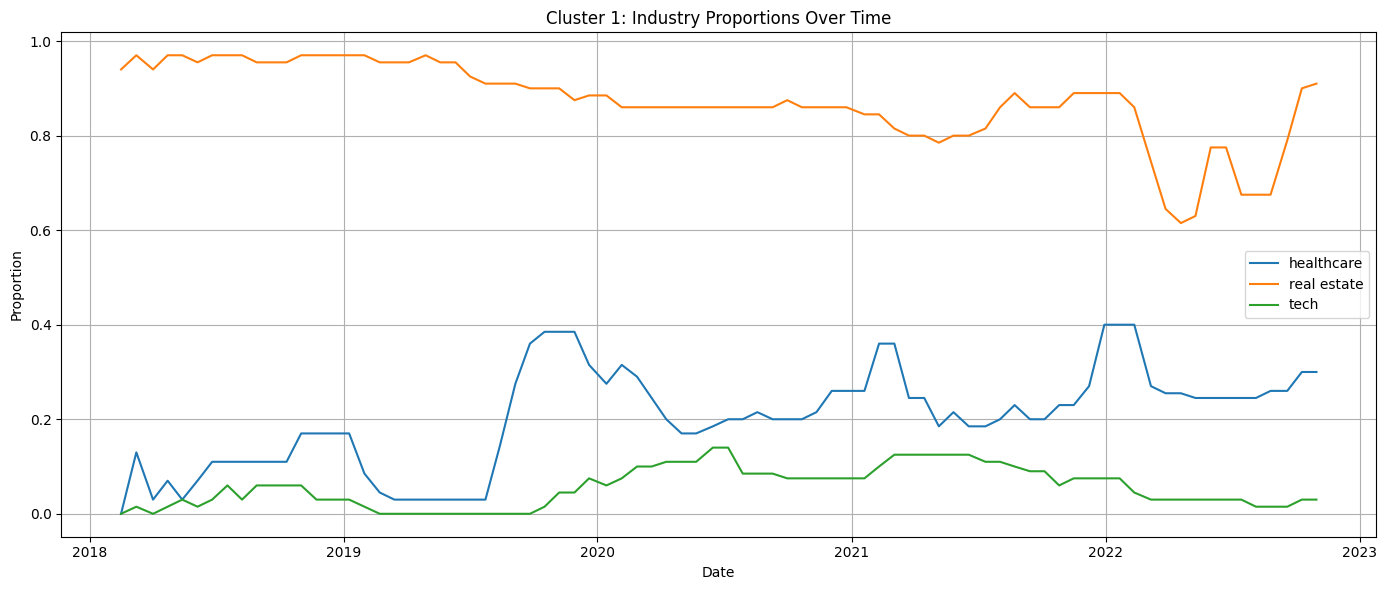

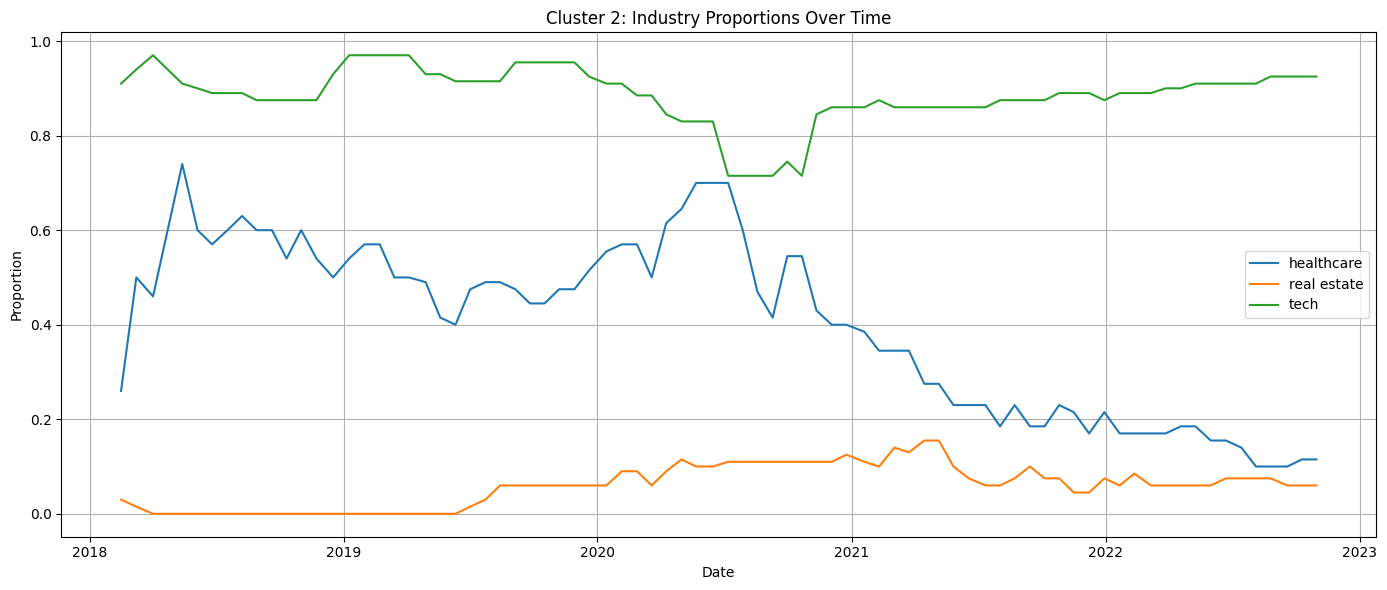

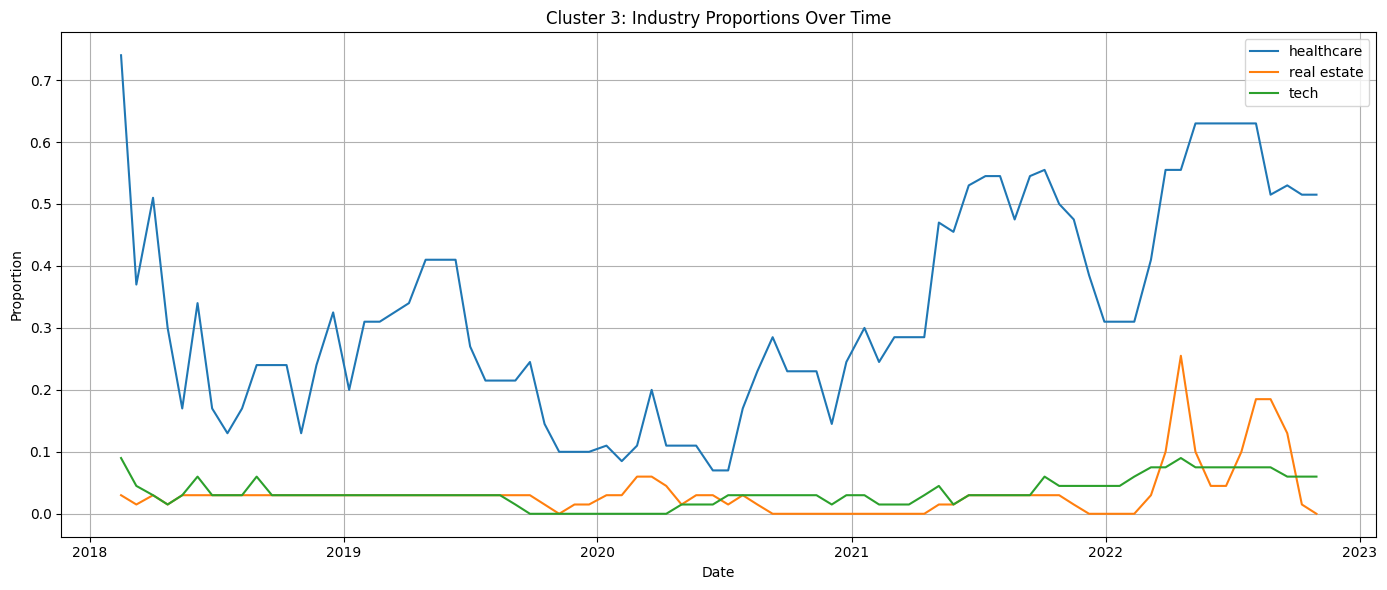

In [ ]:
evolution = model.cluster_evolution(default_tickers, start, end, 3, industries = ["tech", "real estate", "healthcare"], window = 60, step = 15, lock_threshold = 0.6)
model.plot_cluster_proportions(evolution, rolling_window = 10)

It's worth noting that the three-cluster model introduces more vacua — more possible minima for the optimization to fall into. While the result shown here is clean and stable, it may take a few runs to reproduce this exact structure. Still, when it works, it highlights the model's capacity to discover meaningful structure without being told what to look for.

# Conclusions

We developed an unsupervised neural network capable of clustering stocks based solely on their return behavior over time. Without access to any industry labels during training, the model consistently discovers groupings that closely align with real-world industry classifications. More importantly, it captures how these groupings evolve — not just during stable periods, but also through times of market stress. In such cases, the model identifies stocks that temporarily diverge from their industry peers. This makes the model a useful tool for understanding how stocks behave — not just in general, but also how that behavior changes over time. It can help predict which stocks can acting differently from the rest of their industry, especially during periods of market stress.